In [22]:
import random
from tqdm import tqdm
import copy
import numpy as np
import pandas as pd
import scipy.signal
import scipy.stats
import statsmodels.stats.rates
from matplotlib import pyplot as plt
from datetime import datetime, timedelta
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller

In [18]:
import warnings
warnings.filterwarnings('ignore')

## Signal generation

Interested in generally 'stationary' statistical time series signals, e.g.
- weakly stationary signals, where only the mean and variance are conserved in time
- predictable non-stationarity in the 1st moment (mean)

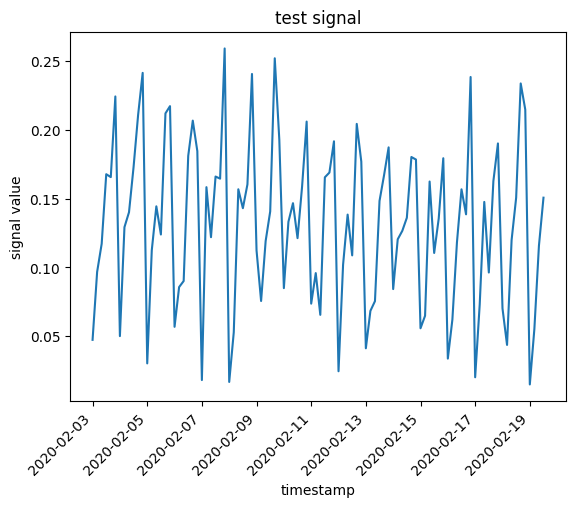

In [86]:
n_sample = 500
s = (2 + np.arange(n_sample) % 6) * 0.03 + np.random.normal(0, 0.03, n_sample)
s[400:] = s[400:] * 0.1
s[s <= 0] = 0.0
t = [datetime(2020, 2, 3) + timedelta(hours=4 * x) for x in range(n_sample)]
df = pd.DataFrame()
df["data"] = s
df["timestamp"] = t
df = df.set_index("timestamp")
plt.plot(df[:100])
plt.xlabel("timestamp")
plt.ylabel("signal value")
plt.title("test signal")
_ = plt.xticks(rotation=45, ha="right")

E.g. amount of data landing in a bucket over time.

Can one set up alerting for changes in the amount of data landing?

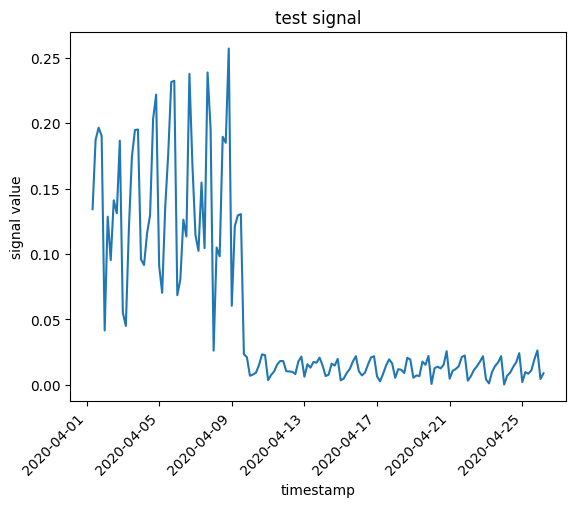

In [87]:
plt.plot(df[350:])
plt.xlabel("timestamp")
plt.ylabel("signal value")
plt.title("test signal")
_ = plt.xticks(rotation=45, ha="right")

## Modelling as a Poisson distribution

A Poisson distribution gives the probability of an event happening (e.g. some data landing) a certain number of times within a given interval of time or space. Can try and construct a hypothesis test for the Poisson distribution changing.

In [82]:
def get_zstats_and_pvalues(df, n_background, n_test):
    s = df["data"]
    n_stats = len(s) - n_background - n_test
    zstats = np.zeros(n_stats)
    pvalues = np.zeros(n_stats)
    for offset in range(n_stats):
        background_window = s[offset:offset + n_background]
        test_window = s[offset + n_background:offset + n_background + n_test]
        res = statsmodels.stats.rates.test_poisson_2indep(
            sum(background_window), 
            n_background, 
            sum(test_window), 
            n_test,
        )
        zstats[offset] = res.statistic
        pvalues[offset] = res.pvalue
    return zstats, pvalues

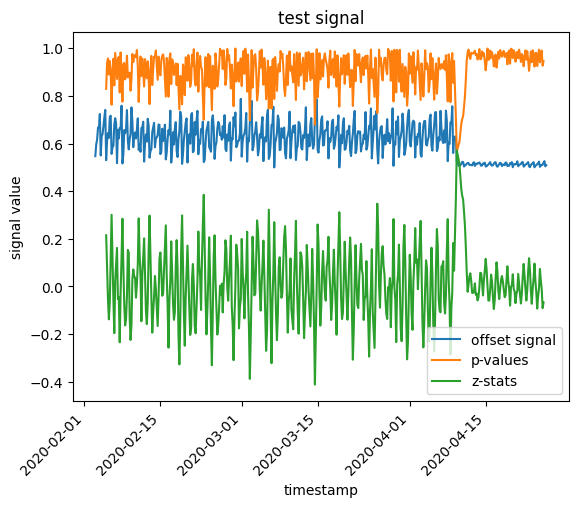

In [88]:
n_background = 12
n_test = 3
zstats, pvalues = get_zstats_and_pvalues(df, n_background, n_test)

plt.plot(df + 0.5, label='offset signal')
plt.plot(t[n_background:-n_test], pvalues, label='p-values')
plt.plot(t[n_background:-n_test], zstats, label='z-stats')
plt.xlabel("timestamp")
plt.ylabel("signal value")
plt.title("test signal")
plt.legend()
_ = plt.xticks(rotation=45, ha="right")

The model is a poor representation of signal. 

One would expect to have a high, roughly constant, p-value before the data drop, and then a sharp drop (to less than 0.1) at the point of data drop.

The fluctuations mirroring the signal show the issue of samples in the signal not being i.i.d.

## Modelling as a forecast problem

Rather than treat this as a hypothesis test problem, due to the temporal correlations between samples, one could treat this as a forecasting problem.

### Intro to auto-regressive and moving average modelling

These models estimate the next term given some previous terms, and accommodate statistical 'error terms' over the previous samples. A timeseries $X_t$ can be modelled by $\text{ARMA}(p,q)$, which is given by  

$ X_t-\alpha_1X_{t-1}- \dots -\alpha_{p}X_{t-p} = \varepsilon_t + \theta_1 \varepsilon_{t-1} + \cdots +\theta_q \varepsilon_{t-q}$

where the $\varepsilon_t$ are i.i.d. and Normally distributed. $q$ refers to a moving-average part of the model, and $p$ refers to an auto-regressive part of the model.

The model will try and work out the current sample from the previous (p) samples and also (the last q) terms from a random process.

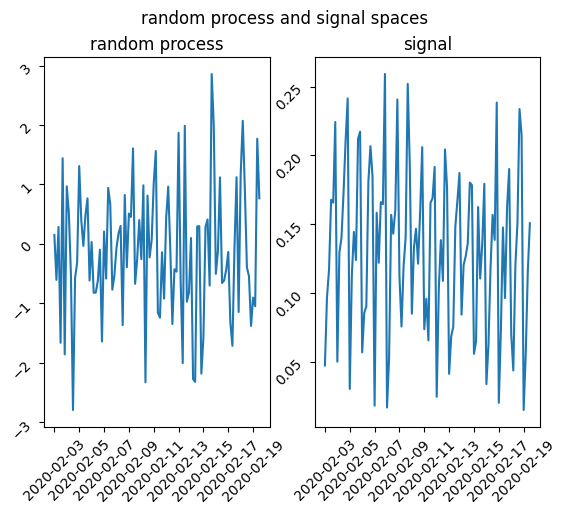

In [89]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('random process and signal spaces')
ax1.plot(t[:100], np.random.normal(size=100))
ax1.set_title("random process")
ax1.tick_params(labelrotation=45)
ax2.plot(df["data"][:100])
ax2.set_title("signal")
ax2.tick_params(labelrotation=45)

### Statistical test for non-stationarity

Using the Augmented Dickey–Fuller test, the null hypothesis is (roughly) the time series is non-stationary and the alternative hypothesis is that the time series is stationary (perhaps with a trend).

In [90]:
result = adfuller(df["data"])
print('ADF Statistic: {}'.format(result[0]))
print('p-value: {}'.format(result[1]))
print('Critical Values:')
for key, value in result[4].items():
    print('\t{}: {}'.format(key, value))

ADF Statistic: -0.5082418193825474
p-value: 0.8903981009275419
Critical Values:
	1%: -3.4439899743408136
	5%: -2.8675550551408353
	10%: -2.569973792117904


The p-value is quite high, and so the null hypothesis has to be accepted, this signal will not be sensible to model as stationary. A numerical derivative does give a test where the p-value is very small, and the null hypothesis can be rejected.

In [91]:
result = adfuller(np.diff(df["data"]))
print('ADF Statistic: {}'.format(result[0]))
print('p-value: {}'.format(result[1]))
print('Critical Values:')
for key, value in result[4].items():
    print('\t{}: {}'.format(key, value))

ADF Statistic: -7.9721867557892505
p-value: 2.762295466106008e-12
Critical Values:
	1%: -3.4439899743408136
	5%: -2.8675550551408353
	10%: -2.569973792117904


So for modelling, we will work with the diff of the signal.

### Tuning the number of samples in the moving average

This can be estimated from looking at how far the temporal correlations go back in time, which can be estimated from the autocorrelation function

Text(0.5, 0, 'lags')

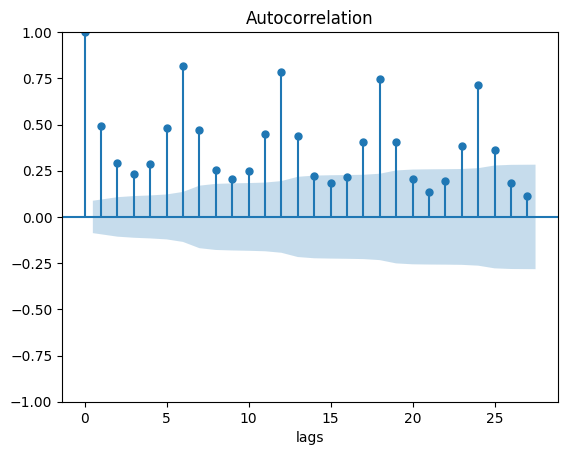

In [92]:
_ = plot_acf(s)
plt.xlabel("lags")

Whilst there are many points above the confidence interval, the correlation peaks first at 6 samples (unsurprisingly from the signal generation, which has a periodicity of 6 samples). This suggests that the moving average will need to be above 6, and may need more samples since further lags are above the confidence interval.

### Tuning the number of samples in the auto-regression

The partial autocorrelation functions omits samples that do not directly contribute to the lag. E.g. lags 1 and 2 for the PACF are the same ast those for the ACF, whereas lag 2 is smaller since it will only use every other sample in the correlation calculation (omitting the lag 1 samples in the signal). 

Text(0.5, 0, 'lags')

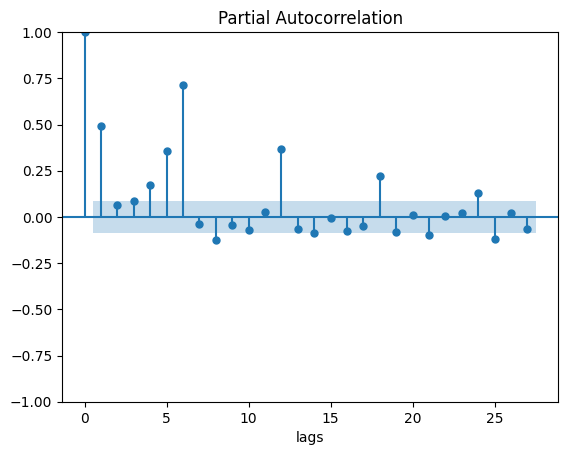

In [93]:
_ = plot_pacf(s, method='ywm')
plt.xlabel("lags")

The correlation exhibits the same peaks every 6 samples, although dips below the confidence thresholds after 1 lag, suggesting a smaller number for the auto-regression

### Modelling the signal

With the tuning analysis above, one can go ahead and try to model the signal

In [31]:
def plot_arima_results(p, d, q, signal, timestamps, n_fit=1000, alpha=0.05):
    s = signal
    t = timestamps
    n_sample = len(signal)
    model = ARIMA(s[:n_fit], order=(p, d, q), dates=t[:n_fit])
    results = model.fit()

    plt.plot(t, s, label="original signal")
    plt.plot(t[:n_fit], results.fittedvalues, color="red", label=f"ARIMA{(p,d,q)} fitted values")

    predictions = results.predict(start=n_fit, end=n_sample-1)
    plt.plot(t[n_fit:], predictions, color="orange", label="prediction")

    forecast = results.get_forecast(n_sample - n_fit).conf_int(alpha=alpha)

    plt.fill_between(t[n_fit:], [x[0] for x in forecast], [x[1] for x in forecast], color=(0.01, 0.4, 0.6, 0.2), label=f"alpha={alpha} confidence interval")
    plt.legend(loc="upper left")
    plt.xlabel("timestamp")
    plt.xticks(rotation=45, ha="right")
    plt.ylabel("signal value")
    plt.title("ARIMA modelling of signal")

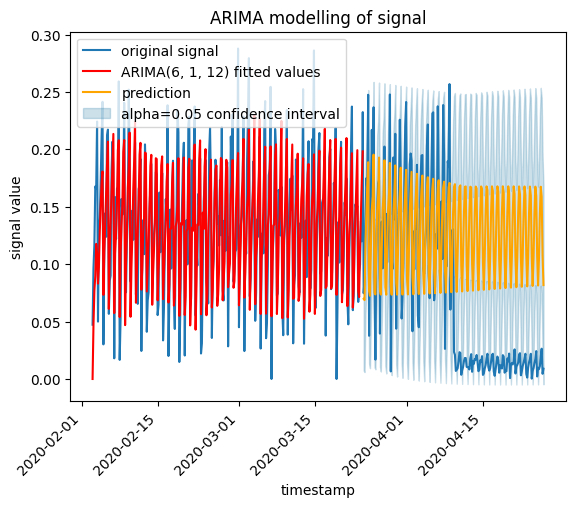

In [95]:
plot_arima_results(6, 1, 12, s, t, 300)

### Constructing an alerting metric using ARIMA

Using previous samples, one can construct a forecast, and see if the new samples marry with that forecast. The metric produced can represent a fractional change in data (based on the forecast to the actual).

In [102]:
def get_stats_from_arima_modelling(p, d, q, signal, timestamps, n_fit, n_gap, n_test=1):
    s = signal
    t = timestamps
    n_stats = len(s) - n_fit - n_gap - (n_test - 1)
    stats = np.zeros(n_stats)
    for offset in tqdm(range(n_stats)):
        model = ARIMA(s[offset:n_fit + offset], order=(p, d, q), dates=t[offset:n_fit + offset])
        results = model.fit()
        predictions = results.predict(start=n_fit, end=n_fit + n_gap + (n_test - 1))
        predictions[predictions <= 0] = 1.0e-10
        stats[offset] = sum(
            s[offset + n_fit + n_gap:offset + n_fit + n_gap + n_test] - predictions[-n_test:]
        ) / sum(predictions[-n_test:])
        # stats[offset] = np.mean(predictions[-n_test:])  # debug
    return stats

In [109]:
start_sample = 250
stop_sample = 450
n_fit = 50
n_gap = 20
n_test = 3
stats = get_stats_from_arima_modelling(
    6, 0, 12, s[start_sample:stop_sample], t[start_sample:stop_sample], n_fit, n_gap, n_test
)

100%|█████████████████████████████████████████| 128/128 [04:19<00:00,  2.03s/it]


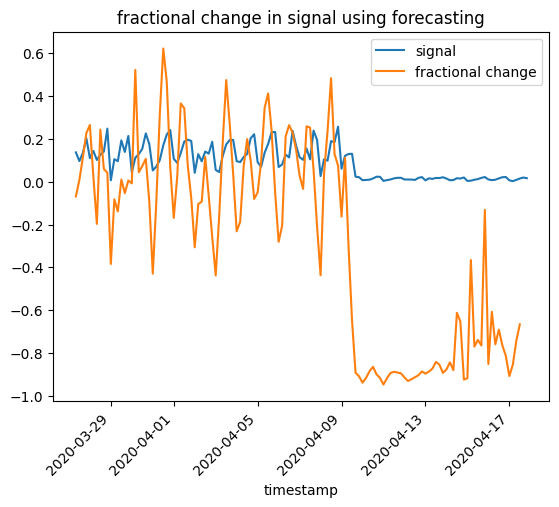

In [110]:
plt.plot(t[start_sample+n_fit+n_gap:stop_sample], s[start_sample+n_fit+n_gap:stop_sample], label="signal")
plt.plot(t[start_sample+n_fit+n_gap:stop_sample - (n_test - 1)], stats, label="fractional change")
plt.legend()
plt.xlabel("timestamp")
plt.title("fractional change in signal using forecasting")
_ = plt.xticks(rotation=45, ha="right")

### Introducing seasonality using SARIMA

Using ARIMA directly above is not the most efficient way of modelling the signal. There is a periodicity, or seasonality in the signal, which SARIMA can accomodate. The same workings as above carry over, with a few extra parameters to model the seasonal part.

In [133]:
def get_stats_from_sarima_modelling(p, d, q, P, D, Q, season_samples, signal, timestamps, n_fit, n_gap, n_test=1):
    s = signal
    t = timestamps
    n_stats = len(s) - n_fit - n_gap - (n_test - 1)
    stats = np.zeros(n_stats)
    for offset in tqdm(range(n_stats)):
        model = SARIMAX(
            s[offset:n_fit + offset], 
            order=(p, d, q), 
            seasonal_order=(P, D, Q, season_samples), 
            dates=t[offset:n_fit + offset]
        )
        results = model.fit(disp=False)
        predictions = results.predict(start=n_fit, end=n_fit + n_gap + (n_test - 1))
        stats[offset] = sum(
            s[offset + n_fit + n_gap:offset + n_fit + n_gap + n_test] - predictions[-n_test:]
        ) / sum(predictions[-n_test:])
        # stats[offset] = np.mean(predictions[-n_test:])  # debug
        stats[stats < -1.0] = -1.0  # dirty frig on outlier
        stats[stats > 1.0] = 1.0  # dirty frig on outlier
    return stats

In [134]:
start_sample = 250
stop_sample = 450
n_fit = 50
n_gap = 20
n_test = 3
sarima_stats = get_stats_from_sarima_modelling(
    1, 0, 1, 1, 0, 1, 6, s[start_sample:stop_sample], t[start_sample:stop_sample], n_fit, n_gap, n_test
)

100%|█████████████████████████████████████████| 128/128 [01:06<00:00,  1.93it/s]


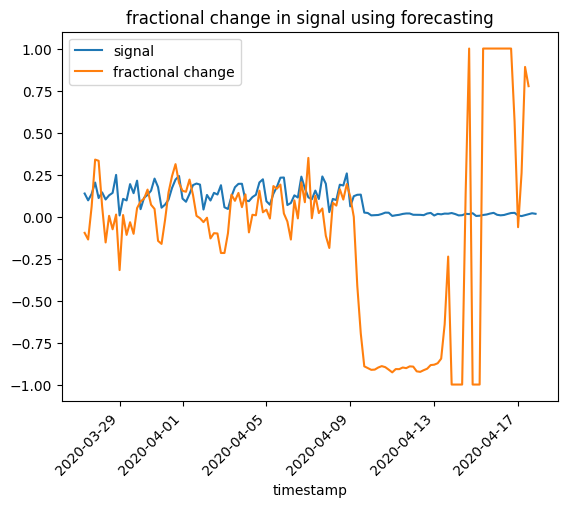

In [135]:
plt.plot(t[start_sample+n_fit+n_gap:stop_sample], s[start_sample+n_fit+n_gap:stop_sample], label="signal")
plt.plot(t[start_sample+n_fit+n_gap:stop_sample - (n_test - 1)], sarima_stats, label="fractional change")
plt.legend()
plt.xlabel("timestamp")
plt.title("fractional change in signal using forecasting")
_ = plt.xticks(rotation=45, ha="right")

## Conclusion

There are a variety of timeseries modelling techniques that can assist with alerting in the change of a time series. For time series with heavy temporal correlations, one method is to forecast the signal, and then compare the actual data with the forecast.